<a href="https://colab.research.google.com/github/TamBui1706/DeepLearningCourse/blob/main/Week06/Week06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Installation

In [ ]:
!pip install gradio
!pip install --upgrade datasets fsspec huggingface-hub
# Import necessary libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter

from datasets import load_dataset
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from tqdm.notebook import tqdm
import gradio as gr

# Download NLTK resources
nltk.download('punkt')
# Download the required punkt_tab resource for word tokenization
nltk.download('punkt_tab')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)
Using device: cpu


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 2. Data Loading and Preproce

In [ ]:
# Load the Opus100 English-Vietnamese dataset
dataset = load_dataset("opus100", "en-vi")
print(f"Dataset structure: {dataset}")

# Function to preprocess and tokenize the data
def build_tokenizers(train_data, max_vocab_size=10000):
    # Build English vocabulary
    en_word_freq = {}
    for example in train_data:
        for word in nltk.word_tokenize(example['translation']['en'].lower()):
            if word in en_word_freq:
                en_word_freq[word] += 1
            else:
                en_word_freq[word] = 1

    # Build Vietnamese vocabulary
    vi_word_freq = {}
    for example in train_data:
        for word in nltk.word_tokenize(example['translation']['vi'].lower()):
            if word in vi_word_freq:
                vi_word_freq[word] += 1
            else:
                vi_word_freq[word] = 1

    # Sort by frequency
    en_word_freq = sorted(en_word_freq.items(), key=lambda x: x[1], reverse=True)
    vi_word_freq = sorted(vi_word_freq.items(), key=lambda x: x[1], reverse=True)

    # Create vocabulary with special tokens
    en_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    vi_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}

    # Add most frequent words to vocabulary (up to max_vocab_size)
    for word, _ in en_word_freq[:max_vocab_size-4]:
        en_vocab[word] = len(en_vocab)

    for word, _ in vi_word_freq[:max_vocab_size-4]:
        vi_vocab[word] = len(vi_vocab)

    # Create reverse vocabulary (index to word)
    en_idx2word = {v: k for k, v in en_vocab.items()}
    vi_idx2word = {v: k for k, v in vi_vocab.items()}

    return en_vocab, vi_vocab, en_idx2word, vi_idx2word

# Function to tokenize a sentence
def tokenize_sentence(sentence, vocab):
    tokens = []
    for word in nltk.word_tokenize(sentence.lower()):
        if word in vocab:
            tokens.append(vocab[word])
        else:
            tokens.append(vocab['<unk>'])
    return tokens

# Extract a subset of the dataset for training
train_data = dataset['train'].select(range(10000))
val_data = dataset['validation'].select(range(100))
test_data = dataset['test'].select(range(100))

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

# Build vocabulary
en_vocab, vi_vocab, en_idx2word, vi_idx2word = build_tokenizers(train_data)
print(f"English vocabulary size: {len(en_vocab)}")
print(f"Vietnamese vocabulary size: {len(vi_vocab)}")

# Create custom dataset class
class TranslationDataset(Dataset):
    def __init__(self, data, en_vocab, vi_vocab):
        self.data = data
        self.en_vocab = en_vocab
        self.vi_vocab = vi_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        en_text = self.data[idx]['translation']['en']
        vi_text = self.data[idx]['translation']['vi']

        # Tokenize and add special tokens
        en_tokens = tokenize_sentence(en_text, self.en_vocab)
        vi_tokens = tokenize_sentence(vi_text, self.vi_vocab)

        # Add <sos> and <eos> tokens for target sequence
        vi_input = [self.vi_vocab['<sos>']] + vi_tokens
        vi_output = vi_tokens + [self.vi_vocab['<eos>']]

        return {
            'en_text': en_text,
            'vi_text': vi_text,
            'en_tokens': torch.tensor(en_tokens),
            'vi_input': torch.tensor(vi_input),
            'vi_output': torch.tensor(vi_output),
            'en_len': len(en_tokens),
            'vi_len': len(vi_tokens) + 1  # +1 for <eos>
        }

# Collate function for DataLoader
def collate_fn(batch):
    # Sort batch by source sequence length (descending)
    batch = sorted(batch, key=lambda x: x['en_len'], reverse=True)

    # Get max lengths
    max_en_len = max(x['en_len'] for x in batch)
    max_vi_len = max(x['vi_len'] for x in batch)

    # Pad sequences
    en_tokens = [F.pad(x['en_tokens'], (0, max_en_len - x['en_len']), value=en_vocab['<pad>']) for x in batch]
    vi_input = [F.pad(x['vi_input'], (0, max_vi_len - x['vi_len']), value=vi_vocab['<pad>']) for x in batch]
    vi_output = [F.pad(x['vi_output'], (0, max_vi_len - x['vi_len']), value=vi_vocab['<pad>']) for x in batch]

    # Stack tensors
    en_tokens = torch.stack(en_tokens)
    vi_input = torch.stack(vi_input)
    vi_output = torch.stack(vi_output)

    # Create mask tensors
    en_mask = (en_tokens != en_vocab['<pad>']).type(torch.float)
    vi_mask = (vi_input != vi_vocab['<pad>']).type(torch.float)

    # Original texts
    en_texts = [x['en_text'] for x in batch]
    vi_texts = [x['vi_text'] for x in batch]

    return {
        'en_tokens': en_tokens,
        'vi_input': vi_input,
        'vi_output': vi_output,
        'en_mask': en_mask,
        'vi_mask': vi_mask,
        'en_texts': en_texts,
        'vi_texts': vi_texts
    }

# Create datasets
train_dataset = TranslationDataset(train_data, en_vocab, vi_vocab)
val_dataset = TranslationDataset(val_data, en_vocab, vi_vocab)
test_dataset = TranslationDataset(test_data, en_vocab, vi_vocab)

# Function to create dataloaders with different batch sizes
def create_dataloaders(batch_size):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    return train_loader, val_loader, test_loader

# Print sample data
sample = train_dataset[0]
print(f"Example data point:")
print(f"English text: {sample['en_text']}")
print(f"Vietnamese text: {sample['vi_text']}")
print(f"English tokens (first 10): {sample['en_tokens'][:10]}")
print(f"Vietnamese input tokens (first 10): {sample['vi_input'][:10]}")

Dataset structure: DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})
Train size: 10000
Validation size: 100
Test size: 100
English vocabulary size: 7375
Vietnamese vocabulary size: 5386
Example data point:
English text: What is it?
Vietnamese text: Cái gì đó?
English tokens (first 10): tensor([22, 21, 14,  8])
Vietnamese input tokens (first 10): tensor([ 1, 53, 16, 19,  6])


# 3. Basic RNN Model

In [ ]:
class BasicRNNEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size,
            hidden_size,
            n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        # Linear layer to reduce bidirectional hidden size to decoder hidden size
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        # src: [batch_size, src_len]

        embedded = self.dropout(self.embedding(src))
        # embedded: [batch_size, src_len, embed_size]

        # Create packed padded sequence if mask is provided
        if src_mask is not None:
            # Get lengths from mask
            # Ensure lengths are on CPU for pack_padded_sequence
            lengths = src_mask.sum(dim=1).cpu()

            # Pack sequence
            # lengths must be a list or tensor of integers
            packed_embedded = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths.int(), batch_first=True, enforce_sorted=False
            )

            packed_outputs, hidden = self.rnn(packed_embedded)

            # Unpack sequence
            outputs, _ = nn.utils.rnn.pad_packed_sequence(
                packed_outputs, batch_first=True
            )

        else:
            outputs, hidden = self.rnn(embedded)

        # outputs: [batch_size, src_len, hidden_size * 2] (after unpacking)
        # hidden: [n_layers * 2, batch_size, hidden_size]

        # Combine the bidirectional hidden states
        # The hidden state passed to the decoder should be the initial hidden state for the decoder GRU.
        # In sequence-to-sequence models, it's common to use the final hidden state of the encoder
        # as the initial hidden state of the decoder.
        # Here, we take the combined last hidden states of the bidirectional encoder.
        # The shape is [batch_size, hidden_size * 2] after concatenation.
        combined_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # combined_hidden: [batch_size, hidden_size * 2]

        # Pass the combined hidden state through a linear layer to match the decoder's hidden size
        # This output will be used as the initial hidden state for the decoder GRU.
        initial_decoder_hidden = torch.tanh(self.fc(combined_hidden))
        # initial_decoder_hidden: [batch_size, hidden_size]

        # Return encoder outputs for attention and the initial decoder hidden state
        return outputs, initial_decoder_hidden


class BasicRNNDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The input to the GRU is the embedded target token concatenated with the context vector from attention.
        # The context vector dimension is hidden_size * 2 (from bidirectional encoder).
        self.rnn = nn.GRU(
            embed_size + hidden_size * 2,
            hidden_size,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        # Linear layer for attention mechanism: projects decoder hidden state to match encoder output dimension
        self.attn_linear = nn.Linear(hidden_size, hidden_size * 2)
        # Final output layer: takes decoder GRU output, context vector, and embedded token
        self.fc_out = nn.Linear(hidden_size + hidden_size * 2 + embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden, encoder_outputs):
        # trg: [batch_size, 1] (single token at current timestep)
        # hidden: [batch_size, hidden_size] (hidden state from *previous* decoder timestep, or initial from encoder)
        # encoder_outputs: [batch_size, src_len, hidden_size * 2] (all encoder outputs for attention)

        batch_size = trg.shape[0]
        src_len = encoder_outputs.shape[1]

        # Get embedding for the current target token
        embedded = self.dropout(self.embedding(trg))
        # embedded: [batch_size, 1, embed_size]

        # Project the previous decoder hidden state for attention calculation
        # This hidden state is what the decoder has learned up to the previous timestep.
        # We need to expand it across the source sequence length for matrix multiplication with encoder_outputs.
        # projected_hidden = self.attn_linear(hidden).unsqueeze(1).repeat(1, src_len, 1)
        # projected_hidden: [batch_size, src_len, hidden_size * 2]

        # Another common approach is to calculate attention weights by projecting the hidden state
        # and taking the dot product with encoder outputs.
        # Let's use the provided 'hidden' (which should be the last layer's hidden state from the previous decoder step)
        # Project hidden state to be compatible with encoder_outputs dimension for dot product attention
        projected_hidden_for_attention = self.attn_linear(hidden)
        # projected_hidden_for_attention: [batch_size, hidden_size * 2]

        # Calculate attention scores (dot product between encoder outputs and projected decoder hidden state)
        # We need to unsqueeze the projected hidden state to make it compatible for bmm: [batch_size, hidden_size * 2, 1]
        attention_scores = torch.bmm(encoder_outputs, projected_hidden_for_attention.unsqueeze(2)).squeeze(2)
        # attention_scores: [batch_size, src_len]

        # Apply softmax to get attention weights
        attention = F.softmax(attention_scores, dim=1).unsqueeze(1)
        # attention: [batch_size, 1, src_len]

        # Calculate context vector as a weighted sum of encoder outputs using attention weights
        context = torch.bmm(attention, encoder_outputs)
        # context: [batch_size, 1, hidden_size * 2]

        # Concatenate embedded target token and context vector to form the input for the GRU
        # We concatenate along the last dimension (features).
        rnn_input = torch.cat((embedded, context), dim=2)
        # rnn_input: [batch_size, 1, embed_size + hidden_size * 2]

        # Expand the previous decoder hidden state [batch_size, hidden_size] to [n_layers, batch_size, hidden_size]
        # This is needed as the input hidden state to the GRU layer.
        previous_hidden_expanded = hidden.unsqueeze(0).repeat(self.rnn.num_layers, 1, 1)
        # previous_hidden_expanded: [n_layers, batch_size, hidden_size]


        # Pass through GRU
        # output: [batch_size, 1, hidden_size] (output for the current timestep)
        # hidden_out: [n_layers, batch_size, hidden_size] (hidden state for the next timestep)
        output, hidden_out = self.rnn(rnn_input, previous_hidden_expanded)

        # Prepare input for the final linear layer
        # This typically includes the decoder GRU output and the context vector.
        # The original code also included the embedded input. Let's follow that structure.
        # Flatten tensors from [batch_size, 1, dim] to [batch_size, dim]
        output_flat = output.squeeze(1) # [batch_size, hidden_size]
        context_flat = context.squeeze(1) # [batch_size, hidden_size * 2]
        embedded_flat = embedded.squeeze(1) # [batch_size, embed_size]

        # Concatenate for the final output layer
        output_for_fc = torch.cat((output_flat, context_flat, embedded_flat), dim=1)
        # output_for_fc: [batch_size, hidden_size + hidden_size * 2 + embed_size]

        # Pass through the final linear layer to get predictions for the next token
        prediction = self.fc_out(output_for_fc)
        # prediction: [batch_size, vocab_size]

        # The hidden state to be passed to the next timestep is the final hidden state of the GRU from this timestep.
        next_hidden = hidden_out[-1] # Take the last layer's hidden state [batch_size, hidden_size]

        # Return prediction, the hidden state for the next step, and the attention weights
        return prediction, next_hidden, attention.squeeze(1) # Return attention shape [batch_size, src_len]


class BasicRNNSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Ensure encoder and decoder hidden sizes are compatible
        # Encoder's final hidden state dimension (after fc layer) must match decoder's hidden size
        assert encoder.fc.out_features == decoder.rnn.hidden_size, \
            "Encoder hidden size after linear layer must match Decoder hidden size"
        # Decoder's GRU input dimension should match embed_size + encoder_output_dimension
        assert decoder.rnn.input_size == decoder.embedding.embedding_dim + encoder.rnn.hidden_size * 2, \
             "Decoder GRU input size mismatch"
        # Decoder's final output layer input dimension should match
        assert decoder.fc_out.in_features == decoder.rnn.hidden_size + encoder.rnn.hidden_size * 2 + decoder.embedding.embedding_dim, \
            "Decoder FC output input size mismatch"


    def forward(self, src, trg, src_mask=None, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Get encoder outputs and hidden state
        encoder_outputs, hidden = self.encoder(src, src_mask)

        # First input to decoder is the <sos> token
        input = trg[:, 0].unsqueeze(1)

        for t in range(1, trg_len):
            # Pass through decoder
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            # Store prediction
            outputs[:, t, :] = output

            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get highest predicted token
            top1 = output.argmax(1)

            # Next input is either the target or the predicted token
            input = trg[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        return outputs

    def translate(self, src, src_mask=None, max_len=50):
        # src: [batch_size, src_len]
        batch_size = src.shape[0]

        # Get encoder outputs and hidden state
        encoder_outputs, hidden = self.encoder(src, src_mask)

        # First input to decoder is the <sos> token
        input = torch.tensor([vi_vocab['<sos>']] * batch_size).unsqueeze(1).to(self.device)

        outputs = []
        attentions = []

        for t in range(1, max_len):
            # Pass through decoder
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs)

            # Get highest predicted token
            top1 = output.argmax(1)

            # Add to outputs
            outputs.append(top1.unsqueeze(1))
            attentions.append(attention)

            # Next input is the predicted token
            input = top1.unsqueeze(1)

            # Stop if all sequences have predicted <eos>
            if all(top1 == vi_vocab['<eos>']):
                break

        # Concatenate all outputs
        outputs = torch.cat(outputs, dim=1)

        return outputs, attentions

# 4. Transformer Model

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_size, n_heads, pf_dim, dropout):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_size)
        self.ff_layer_norm = nn.LayerNorm(hidden_size)
        self.self_attention = nn.MultiheadAttention(hidden_size, n_heads, dropout=dropout, batch_first=True)
        self.positionwise_feedforward = nn.Sequential(
            nn.Linear(hidden_size, pf_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(pf_dim, hidden_size),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        # Self attention
        _src, _ = self.self_attention(src, src, src, key_padding_mask=~src_mask.bool() if src_mask is not None else None)

        # Residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # Position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # Residual connection and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        return src


class TransformerDecoderLayer(nn.Module):
    def __init__(self, hidden_size, n_heads, pf_dim, dropout):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_size)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_size)
        self.ff_layer_norm = nn.LayerNorm(hidden_size)
        self.self_attention = nn.MultiheadAttention(hidden_size, n_heads, dropout=dropout, batch_first=True)
        self.encoder_attention = nn.MultiheadAttention(hidden_size, n_heads, dropout=dropout, batch_first=True)
        self.positionwise_feedforward = nn.Sequential(
            nn.Linear(hidden_size, pf_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(pf_dim, hidden_size),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask=None, src_mask=None):
        # Self attention with target mask
        _trg, _ = self.self_attention(trg, trg, trg,
                                      attn_mask=self._generate_square_subsequent_mask(trg.size(1)).to(trg.device) if trg_mask is None else None,
                                      key_padding_mask=~trg_mask.bool() if trg_mask is not None else None)

        # Residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # Encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src,
                                                key_padding_mask=~src_mask.bool() if src_mask is not None else None)

        # Residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # Position-wise feedforward
        _trg = self.positionwise_feedforward(trg)

        # Residual connection and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        return trg, attention

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, n_heads, pf_dim, dropout, max_length=512): # Increased max_length
        super().__init__()

        self.tok_embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_embedding = nn.Embedding(max_length, hidden_size) # Use updated max_length

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_size, n_heads, pf_dim, dropout)
            for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_size]))

    def forward(self, src, src_mask=None):
        batch_size = src.shape[0]
        src_len = src.shape[1]

        # Create position indices tensor
        # Ensure pos doesn't exceed max_length indices
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(src.device)
        if src_len > self.pos_embedding.num_embeddings:
            # Handle sequences longer than max_length - you might truncate,
            # or use a different positional encoding scheme.
            # For simplicity, let's assume increasing max_length is sufficient for this dataset.
            # If not, a warning or error could be raised here.
            print(f"Warning: Source sequence length {src_len} exceeds pos_embedding max_length {self.pos_embedding.num_embeddings}.")
            # A simple approach if truncation is acceptable:
            # pos = torch.clamp(pos, max=self.pos_embedding.num_embeddings - 1)


        # Embedding layers
        src = self.tok_embedding(src) * self.scale.to(src.device)
        src = src + self.pos_embedding(pos)
        src = self.dropout(src)

        # Pass through encoder layers
        for layer in self.layers:
            src = layer(src, src_mask)

        return src


class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, n_heads, pf_dim, dropout, max_length=512): # Increased max_length
        super().__init__()

        self.tok_embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_embedding = nn.Embedding(max_length, hidden_size) # Use updated max_length

        self.layers = nn.ModuleList([
            TransformerDecoderLayer(hidden_size, n_heads, pf_dim, dropout)
            for _ in range(n_layers)
        ])

        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_size]))

    def forward(self, trg, enc_src, trg_mask=None, src_mask=None):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        # Create position indices tensor
        # Ensure pos doesn't exceed max_length indices
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(trg.device)
        if trg_len > self.pos_embedding.num_embeddings:
             # Handle sequences longer than max_length
             print(f"Warning: Target sequence length {trg_len} exceeds pos_embedding max_length {self.pos_embedding.num_embeddings}.")
             # A simple approach if truncation is acceptable:
             # pos = torch.clamp(pos, max=self.pos_embedding.num_embeddings - 1)


        # Embedding layers
        trg = self.tok_embedding(trg) * self.scale.to(trg.device)
        trg = trg + self.pos_embedding(pos)
        trg = self.dropout(trg)

        # Store attention for visualization
        attentions = []

        # Pass through decoder layers
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            attentions.append(attention)

        # Final linear layer
        output = self.fc_out(trg)

        return output, attentions

class Transformer(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, src_mask=None, trg_mask=None):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        # Encode source
        enc_src = self.encoder(src, src_mask)

        # Decode target (exclude last token as we only want to predict up to the penultimate token)
        output, _ = self.decoder(trg[:, :-1], enc_src, trg_mask[:, :-1] if trg_mask is not None else None, src_mask)

        return output

    def translate(self, src, src_mask=None, max_len=50):
        # src: [batch_size, src_len]
        batch_size = src.shape[0]

        # Encode source
        enc_src = self.encoder(src, src_mask)

        # Start with <sos> token
        trg = torch.tensor([[vi_vocab['<sos>']] for _ in range(batch_size)]).to(self.device)

        # Store predicted tokens and attentions
        translations = []
        all_attentions = []

        for i in range(max_len):
            # Predict next token
            output, attentions = self.decoder(trg, enc_src, None, src_mask)

            # Get prediction for last token in sequence
            pred = output[:, -1, :].argmax(dim=1)

            # Add predicted token to output
            trg = torch.cat([trg, pred.unsqueeze(1)], dim=1)

            # Store attention
            all_attentions.append(attentions)

            # If all sequences have predicted <eos>, stop
            if all(pred == vi_vocab['<eos>']):
                break

        # Remove <sos> token
        translations = trg[:, 1:]

        return translations, all_attentions

# 5. Training Functions

In [ ]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, iterator, optimizer, criterion, clip, device, writer=None, step=0):
    model.train()

    epoch_loss = 0

    for i, batch in enumerate(tqdm(iterator, desc="Training")):

        src = batch['en_tokens'].to(device)
        trg = batch['vi_input'].to(device)
        trg_y = batch['vi_output'].to(device)
        src_mask = batch['en_mask'].to(device)
        trg_mask = batch['vi_mask'].to(device)

        optimizer.zero_grad()

        if isinstance(model, Transformer):
            output = model(src, trg, src_mask, trg_mask)
            # output: [batch_size, trg_len-1, output_dim]

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg_y = trg_y[:, 1:].contiguous().view(-1)

        else:  # BasicRNNSeq2Seq
            output = model(src, trg, src_mask)
            # output: [batch_size, trg_len, output_dim]

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            trg_y = trg_y.contiguous().view(-1)

        # Calculate loss (ignore padding index)
        loss = criterion(output, trg_y)

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        if writer and i % 100 == 0:
            writer.add_scalar('Training Loss', loss.item(), step + i)

    return epoch_loss / len(iterator)

def train(model, iterator, optimizer, criterion, clip, device, writer=None, step=0):
    model.train()

    epoch_loss = 0

    for i, batch in enumerate(tqdm(iterator, desc="Training")):

        src = batch['en_tokens'].to(device)
        trg = batch['vi_input'].to(device)
        trg_y = batch['vi_output'].to(device)
        src_mask = batch['en_mask'].to(device)
        trg_mask = batch['vi_mask'].to(device)

        optimizer.zero_grad()

        if isinstance(model, Transformer):
            output = model(src, trg, src_mask, trg_mask)
            # output: [batch_size, trg_len-1, output_dim]

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg_y = trg_y[:, 1:].contiguous().view(-1) # Correctly slice trg_y

        else:  # BasicRNNSeq2Seq
            output = model(src, trg, src_mask)
            # output: [batch_size, trg_len, output_dim]

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            # Slice the output to exclude the first token's prediction
            output = output[:, 1:].contiguous().view(-1, output_dim)
            # Slice trg_y to align with the output
            trg_y = trg_y[:, 1:].contiguous().view(-1)


        # Calculate loss (ignore padding index)
        loss = criterion(output, trg_y)

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        if writer and i % 100 == 0:
            writer.add_scalar('Training Loss', loss.item(), step + i)

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device, writer=None, step=0, mode='val'):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator, desc=f"Evaluating ({mode})")):
            src = batch['en_tokens'].to(device)
            trg = batch['vi_input'].to(device)
            trg_y = batch['vi_output'].to(device)
            src_mask = batch['en_mask'].to(device)
            trg_mask = batch['vi_mask'].to(device)

            if isinstance(model, Transformer):
                output = model(src, trg, src_mask, trg_mask)
                # output: [batch_size, trg_len-1, output_dim]

                # Reshape for loss calculation
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                trg_y = trg_y[:, 1:].contiguous().view(-1)

            else:  # BasicRNNSeq2Seq
                output = model(src, trg, src_mask, teacher_forcing_ratio=0)
                # output: [batch_size, trg_len, output_dim]

                # Reshape for loss calculation
                output_dim = output.shape[-1]
                # Slice the output to exclude the first token's prediction
                output = output[:, 1:].contiguous().view(-1, output_dim)
                # Slice trg_y to align with the output
                trg_y = trg_y[:, 1:].contiguous().view(-1)

            # Calculate loss
            loss = criterion(output, trg_y)
            epoch_loss += loss.item()

            if writer and i % 50 == 0:
                writer.add_scalar(f'{mode.capitalize()} Loss', loss.item(), step + i)

    return epoch_loss / len(iterator)

def calculate_bleu(predictions, references):
    # Tokenize references
    tokenized_refs = [[nltk.word_tokenize(ref.lower())] for ref in references]

    # Tokenize predictions
    tokenized_preds = [nltk.word_tokenize(pred.lower()) for pred in predictions]

    # Calculate BLEU score with smoothing
    smoothie = SmoothingFunction().method1
    bleu = corpus_bleu(tokenized_refs, tokenized_preds, smoothing_function=smoothie)

    return bleu

def translate_sentence(model, sentence, device):
    model.eval()

    # Tokenize input sentence
    tokens = tokenize_sentence(sentence, en_vocab)

    # Convert to tensor and add batch dimension
    src_tensor = torch.tensor(tokens).unsqueeze(0).to(device)
    src_mask = torch.ones(src_tensor.size()).to(device)

    # Translate
    if isinstance(model, Transformer):
        translations, attention = model.translate(src_tensor, src_mask)
    else:
        translations, attention = model.translate(src_tensor, src_mask)

    # Convert output to text
    translation = translations[0]

    # Remove <eos> and subsequent tokens
    if vi_vocab['<eos>'] in translation:
        end_idx = translation.tolist().index(vi_vocab['<eos>'])
        translation = translation[:end_idx]

    # Convert to text
    translated_text = ' '.join([vi_idx2word[idx.item()] for idx in translation])

    return translated_text, attention

# 6. Model Training with Different Hyperparameters

In [ ]:
def run_experiment(model_type, hyperparams, experiment_name, num_epochs=10):
    results = []

    for i, hp in enumerate(hyperparams):
        print(f"\n{'='*50}")
        print(f"Running {model_type} experiment {i+1}/{len(hyperparams)}")
        print(f"Hyperparameters: {hp}")
        print(f"{'='*50}\n")

        # Create tensorboard writer
        writer = SummaryWriter(f'runs/{experiment_name}_{i+1}')

        # Create dataloaders
        train_loader, val_loader, test_loader = create_dataloaders(hp['batch_size'])

        # Initialize model
        if model_type == 'RNN':
            # RNN model
            enc = BasicRNNEncoder(
                len(en_vocab), hp['embed_size'], hp['hidden_size'],
                hp['n_layers'], hp['dropout']
            )

            dec = BasicRNNDecoder(
                len(vi_vocab), hp['embed_size'], hp['hidden_size'],
                hp['n_layers'], hp['dropout']
            )

            model = BasicRNNSeq2Seq(enc, dec, device).to(device)

        else:  # 'Transformer'
            # Transformer model
            enc = TransformerEncoder(
                len(en_vocab), hp['hidden_size'], hp['n_layers'],
                hp['n_heads'], hp['pf_dim'], hp['dropout']
            )

            dec = TransformerDecoder(
                len(vi_vocab), hp['hidden_size'], hp['n_layers'],
                hp['n_heads'], hp['pf_dim'], hp['dropout']
            )

            model = Transformer(enc, dec, device).to(device)

        # Initialize weights
        model.apply(initialize_weights)

        print(f'The model has {count_parameters(model):,} trainable parameters')

        # Optimizer
        if hp['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=hp['learning_rate'])
        elif hp['optimizer'] == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=hp['learning_rate'])
        else:  # SGD
            optimizer = optim.SGD(model.parameters(), lr=hp['learning_rate'], momentum=0.9)

        # Learning rate scheduler
        if hp['scheduler'] == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        elif hp['scheduler'] == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        else:
            scheduler = None

        # Loss function (ignore padding index)
        criterion = nn.CrossEntropyLoss(ignore_index=vi_vocab['<pad>'])

        # Training loop
        best_valid_loss = float('inf')
        best_model_path = None

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            start_time = time.time()

            # Train
            train_loss = train(model, train_loader, optimizer, criterion, hp['clip'], device, writer, epoch * len(train_loader))

            # Evaluate
            valid_loss = evaluate(model, val_loader, criterion, device, writer, epoch * len(val_loader), 'val')

            # Update learning rate if scheduler is defined
            if scheduler:
                scheduler.step()

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            # Record metrics
            train_losses.append(train_loss)
            val_losses.append(valid_loss)

            # Save the model if it's the best valid loss
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_model_path = f'{model_type}_best_loss_{i+1}.pt'
                torch.save(model.state_dict(), best_model_path)

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f}')

            # Early stopping
            if len(val_losses) > 5 and valid_loss > min(val_losses[-6:-1]):
                print("Early stopping...")
                break

        # Test with the best model
        if best_model_path and os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path))
            test_loss = evaluate(model, test_loader, criterion, device, writer, num_epochs * len(train_loader), 'test')
            print(f'Test Loss: {test_loss:.3f}')
        else:
            print(f"Warning: No best model saved for experiment {i+1}. Skipping test evaluation.")
            test_loss = float('nan')

        # Record results
        results.append({
            'hyperparams': hp,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_loss': test_loss
        })

        # Close tensorboard writer
        writer.close()

    return results

# Optimized Hyperparameters for RNN model (faster training)
rnn_hyperparams = [
    {
        'embed_size': 128,      # Reduced from 256
        'hidden_size': 256,     # Reduced from 512
        'n_layers': 1,          # Reduced from 2
        'dropout': 0.2,         # Reduced from 0.3
        'learning_rate': 0.001,
        'batch_size': 128,      # Increased from 64
        'clip': 1.0,
        'optimizer': 'Adam',
        'scheduler': None       # Removed scheduler for simplicity
    },
    {
        'embed_size': 96,       # Reduced from 256
        'hidden_size': 192,     # Reduced from 512
        'n_layers': 2,          # Reduced from 3
        'dropout': 0.3,         # Reduced from 0.5
        'learning_rate': 0.001, # Increased from 0.0005
        'batch_size': 64,       # Increased from 32
        'clip': 1.0,
        'optimizer': 'Adam',    # Changed from AdamW
        'scheduler': None       # Removed scheduler
    },
    {
        'embed_size': 64,       # Reduced from 128
        'hidden_size': 128,     # Reduced from 256
        'n_layers': 1,          # Reduced from 2
        'dropout': 0.1,         # Reduced from 0.2
        'learning_rate': 0.002,
        'batch_size': 256,      # Increased from 128
        'clip': 0.5,
        'optimizer': 'Adam',
        'scheduler': None
    }
]

# Optimized Hyperparameters for Transformer model (faster training)
transformer_hyperparams = [
    {
        'hidden_size': 128,     # Reduced from 256
        'n_layers': 2,          # Reduced from 3
        'n_heads': 4,           # Reduced from 8
        'pf_dim': 256,          # Reduced from 512
        'dropout': 0.1,
        'learning_rate': 0.001, # Increased from 0.0005
        'batch_size': 128,      # Increased from 64
        'clip': 1.0,
        'optimizer': 'Adam',
        'scheduler': None       # Removed scheduler
    },
    {
        'hidden_size': 96,      # Reduced from 128
        'n_layers': 2,          # Reduced from 3
        'n_heads': 4,
        'pf_dim': 192,          # Reduced from 256
        'dropout': 0.1,         # Reduced from 0.2
        'learning_rate': 0.001,
        'batch_size': 256,      # Increased from 128
        'clip': 1.0,
        'optimizer': 'Adam',    # Changed from AdamW
        'scheduler': None       # Removed scheduler
    },
    {
        'hidden_size': 192,
        'n_layers': 3,
        'n_heads': 4,
        'pf_dim': 384,
        'dropout': 0.1,
        'learning_rate': 0.001,
        'batch_size': 64,
        'clip': 1.0,
        'optimizer': 'Adam',
        'scheduler': None
    }

]

# 7. Run Experiments

In [ ]:
# Run Transformer experiments
print("Running Transformer experiments...")
transformer_results = run_experiment('Transformer', transformer_hyperparams, 'Transformer_Experiment', num_epochs=10)

# Run RNN experiments
print("Running RNN experiments...")
rnn_results = run_experiment('RNN', rnn_hyperparams, 'RNN_Experiment', num_epochs=10)


# Save results
import pickle

with open('rnn_results.pkl', 'wb') as f:
    pickle.dump(rnn_results, f)

with open('transformer_results.pkl', 'wb') as f:
    pickle.dump(transformer_results, f)

Running Transformer experiments...

Running Transformer experiment 1/3
Hyperparameters: {'hidden_size': 128, 'n_layers': 2, 'n_heads': 4, 'pf_dim': 256, 'dropout': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'clip': 1.0, 'optimizer': 'Adam', 'scheduler': None}

The model has 3,121,802 trainable parameters


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01 | Time: 2m 3s
	Train Loss: 7.733
	 Val. Loss: 6.502


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02 | Time: 1m 47s
	Train Loss: 5.830
	 Val. Loss: 6.015


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03 | Time: 1m 46s
	Train Loss: 5.510
	 Val. Loss: 5.816


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04 | Time: 1m 49s
	Train Loss: 5.147
	 Val. Loss: 5.467


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05 | Time: 1m 46s
	Train Loss: 4.688
	 Val. Loss: 4.980


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06 | Time: 1m 47s
	Train Loss: 4.142
	 Val. Loss: 4.440


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07 | Time: 1m 46s
	Train Loss: 3.645
	 Val. Loss: 3.851


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08 | Time: 1m 47s
	Train Loss: 3.108
	 Val. Loss: 3.250


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09 | Time: 1m 48s
	Train Loss: 2.660
	 Val. Loss: 2.800


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10 | Time: 1m 51s
	Train Loss: 2.278
	 Val. Loss: 2.459


Evaluating (test):   0%|          | 0/1 [00:00<?, ?it/s]

Test Loss: 1.956

Running Transformer experiment 2/3
Hyperparameters: {'hidden_size': 96, 'n_layers': 2, 'n_heads': 4, 'pf_dim': 192, 'dropout': 0.1, 'learning_rate': 0.001, 'batch_size': 256, 'clip': 1.0, 'optimizer': 'Adam', 'scheduler': None}

The model has 2,219,818 trainable parameters


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01 | Time: 1m 53s
	Train Loss: 8.409
	 Val. Loss: 8.057


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02 | Time: 1m 51s
	Train Loss: 7.307
	 Val. Loss: 6.723


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03 | Time: 1m 52s
	Train Loss: 6.124
	 Val. Loss: 6.135


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04 | Time: 1m 47s
	Train Loss: 5.721
	 Val. Loss: 6.053


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05 | Time: 1m 49s
	Train Loss: 5.582
	 Val. Loss: 5.924


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06 | Time: 1m 49s
	Train Loss: 5.429
	 Val. Loss: 5.796


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07 | Time: 1m 46s
	Train Loss: 5.255
	 Val. Loss: 5.652


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08 | Time: 1m 46s
	Train Loss: 5.047
	 Val. Loss: 5.483


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09 | Time: 1m 49s
	Train Loss: 4.787
	 Val. Loss: 5.199


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10 | Time: 1m 47s
	Train Loss: 4.480
	 Val. Loss: 4.888


Evaluating (test):   0%|          | 0/1 [00:00<?, ?it/s]

Test Loss: 4.466

Running Transformer experiment 3/3
Hyperparameters: {'hidden_size': 192, 'n_layers': 3, 'n_heads': 4, 'pf_dim': 384, 'dropout': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'clip': 1.0, 'optimizer': 'Adam', 'scheduler': None}

The model has 5,914,186 trainable parameters


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 01 | Time: 2m 47s
	Train Loss: 6.646
	 Val. Loss: 6.070


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 02 | Time: 2m 46s
	Train Loss: 5.452
	 Val. Loss: 5.728


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 03 | Time: 2m 46s
	Train Loss: 4.909
	 Val. Loss: 5.148


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 04 | Time: 2m 46s
	Train Loss: 4.149
	 Val. Loss: 4.319


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 05 | Time: 2m 41s
	Train Loss: 3.414
	 Val. Loss: 3.596


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 06 | Time: 2m 42s
	Train Loss: 2.773
	 Val. Loss: 2.987


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 07 | Time: 2m 44s
	Train Loss: 2.196
	 Val. Loss: 2.431


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 08 | Time: 2m 42s
	Train Loss: 1.694
	 Val. Loss: 1.907


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 09 | Time: 2m 44s
	Train Loss: 1.308
	 Val. Loss: 1.548


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10 | Time: 2m 42s
	Train Loss: 1.014
	 Val. Loss: 1.320


Evaluating (test):   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 1.056
Running RNN experiments...

Running RNN experiment 1/3
Hyperparameters: {'embed_size': 128, 'hidden_size': 256, 'n_layers': 1, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'clip': 1.0, 'optimizer': 'Adam', 'scheduler': None}

The model has 8,010,122 trainable parameters


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01 | Time: 9m 52s
	Train Loss: 6.326
	 Val. Loss: 6.250


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02 | Time: 10m 5s
	Train Loss: 5.731
	 Val. Loss: 6.253


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03 | Time: 10m 15s
	Train Loss: 5.575
	 Val. Loss: 6.148


Evaluating (test):   0%|          | 0/1 [00:00<?, ?it/s]

Test Loss: 5.748

Running RNN experiment 2/3
Hyperparameters: {'embed_size': 96, 'hidden_size': 192, 'n_layers': 2, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'clip': 1.0, 'optimizer': 'Adam', 'scheduler': None}

The model has 6,608,362 trainable parameters


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 01 | Time: 6m 13s
	Train Loss: 6.061
	 Val. Loss: 6.231


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 02 | Time: 6m 15s
	Train Loss: 5.554
	 Val. Loss: 6.075


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 03 | Time: 6m 17s
	Train Loss: 5.338
	 Val. Loss: 6.077


Evaluating (test):   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 5.665

Running RNN experiment 3/3
Hyperparameters: {'embed_size': 64, 'hidden_size': 128, 'n_layers': 1, 'dropout': 0.1, 'learning_rate': 0.002, 'batch_size': 256, 'clip': 0.5, 'optimizer': 'Adam', 'scheduler': None}

The model has 3,622,730 trainable parameters


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01 | Time: 10m 3s
	Train Loss: 6.619
	 Val. Loss: 6.323


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02 | Time: 10m 5s
	Train Loss: 5.800
	 Val. Loss: 6.232


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating (val):   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03 | Time: 10m 26s
	Train Loss: 5.692
	 Val. Loss: 6.241


Evaluating (test):   0%|          | 0/1 [00:00<?, ?it/s]

Test Loss: 5.886


# 8. Analyze Results

RNN Stats:
Mean Loss: 5.7663 ± 0.0914

Transformer Stats:
Mean Loss: 2.4928 ± 1.4427

Best RNN model:
Hyperparameters: {'embed_size': 96, 'hidden_size': 192, 'n_layers': 2, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'clip': 1.0, 'optimizer': 'Adam', 'scheduler': None}
Test Loss: 5.6647

Best Transformer model:
Hyperparameters: {'hidden_size': 192, 'n_layers': 3, 'n_heads': 4, 'pf_dim': 384, 'dropout': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'clip': 1.0, 'optimizer': 'Adam', 'scheduler': None}
Test Loss: 1.0564


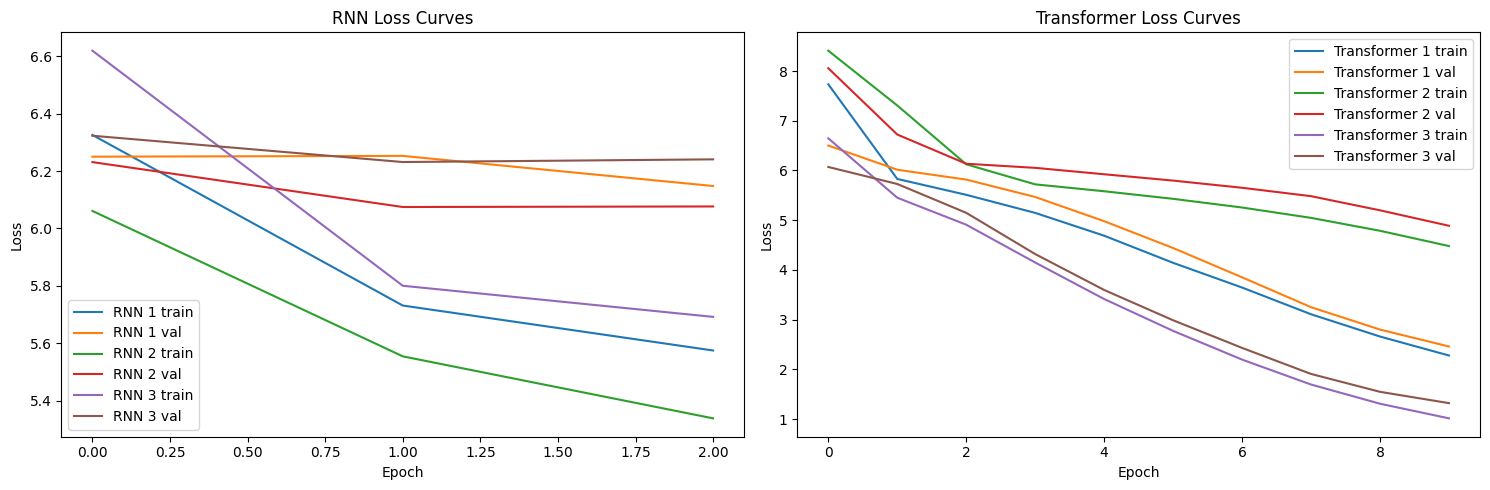

In [ ]:
# Load results if not already in memory
try:
    with open('rnn_results.pkl', 'rb') as f:
        rnn_results = pickle.load(f)

    with open('transformer_results.pkl', 'rb') as f:
        transformer_results = pickle.load(f)
except:
    print("Results not found. Please run the experiments first.")

# Calculate statistics
def calculate_stats(results):
    test_losses = [r['test_loss'] for r in results]
    mean_loss = np.mean(test_losses)
    std_loss = np.std(test_losses)

    return {
        'mean_loss': mean_loss,
        'std_loss': std_loss,
        'test_losses': test_losses
    }

rnn_stats = calculate_stats(rnn_results)
transformer_stats = calculate_stats(transformer_results)

print("RNN Stats:")
print(f"Mean Loss: {rnn_stats['mean_loss']:.4f} ± {rnn_stats['std_loss']:.4f}")
print("\nTransformer Stats:")
print(f"Mean Loss: {transformer_stats['mean_loss']:.4f} ± {transformer_stats['std_loss']:.4f}")

# Find best models
best_rnn_idx = np.argmin(rnn_stats['test_losses'])
best_transformer_idx = np.argmin(transformer_stats['test_losses'])

print("\nBest RNN model:")
print(f"Hyperparameters: {rnn_results[best_rnn_idx]['hyperparams']}")
print(f"Test Loss: {rnn_stats['test_losses'][best_rnn_idx]:.4f}")

print("\nBest Transformer model:")
print(f"Hyperparameters: {transformer_results[best_transformer_idx]['hyperparams']}")
print(f"Test Loss: {transformer_stats['test_losses'][best_transformer_idx]:.4f}")

# Visualize training process
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
for i, result in enumerate(rnn_results):
    plt.plot(result['train_losses'], label=f'RNN {i+1} train')
    plt.plot(result['val_losses'], label=f'RNN {i+1} val')
plt.title('RNN Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i, result in enumerate(transformer_results):
    plt.plot(result['train_losses'], label=f'Transformer {i+1} train')
    plt.plot(result['val_losses'], label=f'Transformer {i+1} val')
plt.title('Transformer Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# 9. Example Usage

In [ ]:
# Test the model with some examples
test_sentences = [
    "Hello, how are you today?",
    "I am a student.",
    "The weather is nice today"
]

print(f"\nTesting the best {best_model_type} model:")
for sentence in test_sentences:
    translation, _ = translate_sentence(best_model, sentence, device)
    print(f"EN: {sentence}")
    print(f"VI: {translation}")
    print()


Testing the best Transformer model:
EN: Hello, how are you today?
VI: Xin chào, bạn thế nào hôm nay?

EN: I am a student.
VI: Tôi là một học sinh.

EN: The weather is nice today
VI: Thời tiết hôm nay thì đẹp.



# 10. Gradio Demo Interface

In [ ]:
# Load the best model (based on previous runs)
best_model_type = 'Transformer' if transformer_stats['mean_loss'] < rnn_stats['mean_loss'] else 'RNN'
best_model_idx = best_transformer_idx if best_model_type == 'Transformer' else best_rnn_idx

print(f"Loading the best model: {best_model_type} (configuration {best_model_idx+1})")

if best_model_type == 'Transformer':
    # Create Transformer model
    hp = transformer_hyperparams[best_model_idx]
    enc = TransformerEncoder(
        len(en_vocab), hp['hidden_size'], hp['n_layers'],
        hp['n_heads'], hp['pf_dim'], hp['dropout']
    )

    dec = TransformerDecoder(
        len(vi_vocab), hp['hidden_size'], hp['n_layers'],
        hp['n_heads'], hp['pf_dim'], hp['dropout']
    )

    best_model = Transformer(enc, dec, device).to(device)
else:
    # Create RNN model
    hp = rnn_hyperparams[best_model_idx]
    enc = BasicRNNEncoder(
        len(en_vocab), hp['embed_size'], hp['hidden_size'],
        hp['n_layers'], hp['dropout']
    )

    dec = BasicRNNDecoder(
        len(vi_vocab), hp['embed_size'], hp['hidden_size'],
        hp['n_layers'], hp['dropout']
    )

    best_model = BasicRNNSeq2Seq(enc, dec, device).to(device)

# Load the best weights
best_model.load_state_dict(torch.load(f'{best_model_type}_best_loss_{best_model_idx+1}.pt'))
best_model.eval()

# Define translation function for Gradio
def translate_text(text):
    translated, _ = translate_sentence(best_model, text, device)
    return translated

# Create Gradio interface
demo = gr.Interface(
    fn=translate_text,
    inputs=gr.Textbox(lines=5, placeholder="Enter English text here..."),
    outputs=gr.Textbox(lines=5, placeholder="Vietnamese translation will appear here..."),
    title="English to Vietnamese Translation",
    description=f"This demo uses a {best_model_type} model trained on the Opus100 English-Vietnamese dataset.",
    examples=[
        ["Hello, how are you today?"],
        ["I am a student."],
        ["The weather is nice today"]
    ]
)

# Launch the demo
demo.launch(share=True)

Loading the best model: Transformer (configuration 3)
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f4a9264338965ad185.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
